In [1]:
import matplotlib
%matplotlib nbagg
from matplotlib import pyplot

In [2]:
from statiskit import (linalg,
                       core,
                       pgm)

In [3]:
import math
import os

In [4]:
%reload_ext rpy2.ipython

In [5]:
%%R
library(glasso)

In [6]:
if not 'K' in os.environ:
    os.environ['K'] = str(10)
K = int(os.environ.get('K'))
simulation = !jupyter nbconvert --ExecutePreprocessor.timeout=3600 --to notebook --execute sampling.ipynb --output sampling.ipynb
data = core.read_csv('data.csv')

In [8]:
if not 'LASSO' in os.environ:
    os.environ['LASSO'] = "linear"
LASSO = os.environ.get('LASSO')
if not 'PENALTIES' in os.environ:
    os.environ['PENALTIES'] = str(K)
PENALTIES = int(os.environ.get('PENALTIES'))

In [9]:
%R data = read.csv('data.csv', header = F, sep="") 
%R -n S = cov(data)

In [10]:
graphs = []
import itertools
S = data.covariance
for u in range(K):
    S[u, u] = float("nan")
    for v in range(u):
        S[u, v] = math.fabs(S[u, v])
        S[v, u] = S[u, v]
for rho in [rho for rho in sorted(itertools.chain(*S.to_list())) if not math.isnan(rho)]:
    %R -i rho
    theta = %R glasso(S, rho=rho)$wi
    graphs.append(pgm.UndirectedGraph(linalg.Matrix(theta)))
graphs = sorted(graphs, key = lambda graph: graph.nb_edges)
graphs = [graphs[0]] + [graphs[index] for index in range(1, len(graphs)) if not graphs[index - 1].nb_edges == graphs[index].nb_edges]

In [26]:
if not 'CRITERION' in os.environ:
    os.environ['CRITERION'] = "SH"
CRITERION = os.environ.get('CRITERION')
CRITERION = 'AICc'

In [12]:
logL = []
for graph in graphs:
    try:
        mle = pgm.graphical_gaussian_estimation(algo='scd',
                                                data=data,
                                                graph=graph)
        logL.append(2 *  mle.estimated.loglikelihood(data))
    except:
        logL.append(float("nan"))
graphs, logL = zip(*[(graph, logl) for graph, logl in zip(graphs, logL) if not math.isnan(logl)])

<IPython.core.display.Javascript object>


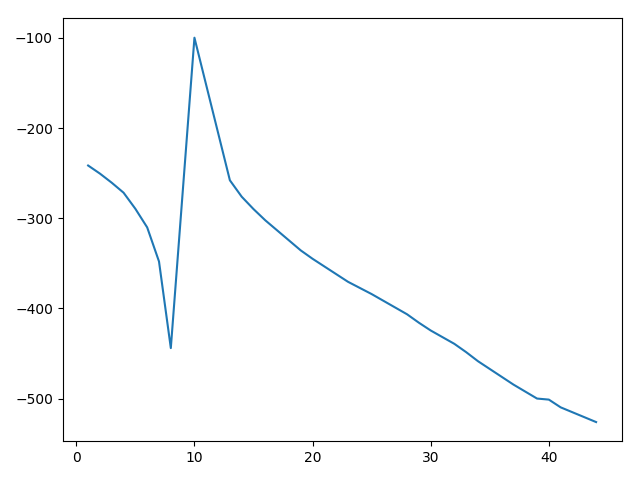

In [27]:
dimensions = [graph.nb_edges for graph in graphs]
fig = pyplot.figure()
if not CRITERION == 'SH':
    total = data.total 
    if CRITERION == 'BIC':
        import math
        logL = [logl - 2 * dimension * math.log(total) for logl, dimension in zip(logL, dimensions)]
    elif CRITERION == 'AIC':
        logL = [logl - 2 * dimension for logl, dimension in zip(logL, dimensions)]
    elif CRITERION == 'AICc':
        logL = [logl - 2 * dimension * (dimension + 1) / (total - dimension - 1) for logl, dimension in zip(logL, dimensions)]
    else:
        raise ValueError("'CRITERION' environment variable")
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(dimensions, logL)
    index = logL.index(max(logL))
else:
    sh = core.SlopeHeuristic(dimensions, logL)
    sh.plot()
    index = sh.selector(sh)
pyplot.tight_layout()

<IPython.core.display.Javascript object>


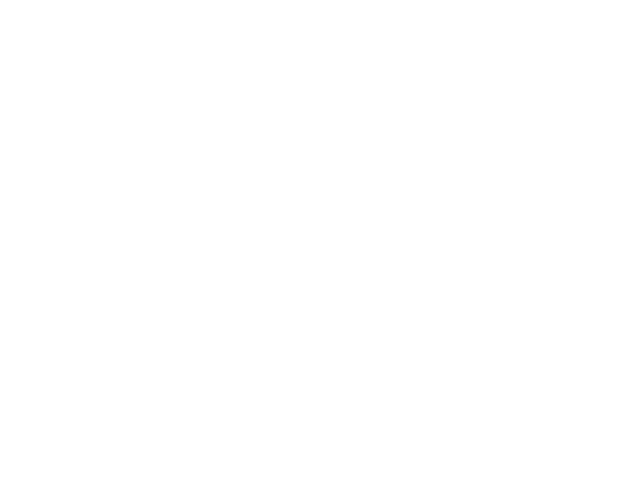

IOError: [Errno 2] No such file or directory: 'graph.gml'

In [28]:
fig = pyplot.figure()
truth = pgm.read_gml('graph.gml')
axes =  truth.to_matrix().plot(axes = fig.add_subplot(121))
axes.set_title('$G$')
axes = graphs[index].to_matrix().plot(axes = fig.add_subplot(122))
axes.set_title('$\widehat{G}_{' + CRITERION + '}$')

In [16]:
def TP(truth, predicted):
    tp = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if truth.has_edge(u, v) and predicted.has_edge(u, v):
                tp += 1
    return tp

def TN(truth, predicted):
    tn = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if not truth.has_edge(u, v) and not predicted.has_edge(u, v):
                tn += 1
    return tn

def FP(truth, predicted):
    fp = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if truth.has_edge(u, v) and not predicted.has_edge(u, v):
                fp += 1
    return fp

def FN(truth, predicted):
    fn = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if not truth.has_edge(u, v) and predicted.has_edge(u, v):
                fn += 1
    return fn

In [17]:
import hashlib
from datetime import datetime
identifier = hashlib.md5(str(datetime.today())).hexdigest()
with open('paths.csv', 'a') as filehandler:
    for graph in graphs:
        tp, tn, fp, fn = TP(truth, graph), TN(truth, graph), FP(truth, graph), FN(truth, graph)
        filehandler.write(','.join([identifier, str(K), str(LASSO), str(tp), str(tn), str(fp), str(fn)]) + '\n')

In [18]:
with open('criteria.csv', 'a') as filehandler:
    tp, tn, fp, fn = TP(truth, graphs[index]), TN(truth, graphs[index]), FP(truth, graphs[index]), FN(truth, graphs[index])
    filehandler.write(','.join([str(K), str(CRITERION), str(tp), str(tn), str(fp), str(fn)]) + '\n')

In [19]:
os.remove('graph.gml')
os.remove('data.csv')